Exploratory data analysis for climbers data from 8a. Database found on Kaggle

In [1]:

# import stuff

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy


In [310]:
sns.set_context(context='talk')

sexes = {0: "Male", 1: "Female"}
colors = ["steelblue", "orchid"]
# print working directory content
print(os.listdir("../climb_analysis"))

['database.sqlite', 'tempb', 'climtemp.py', '.DS_Store', 'climb.py', 'population.csv', '.ipynb_checkpoints', '.git', '.vscode', 'climb.ipynb']


In [3]:
# load data for boulders

#boulder = pd.read_sql_query("SELECT * FROM ascent WHERE climb_type = 1 AND user_id in (SELECT id FROM user  WHERE height <='230' AND height >= '130' AND weight  >0) ;", con)

In [4]:
# load database and load users and lead data
con = sqlite3.connect('../climb_analysis/database.sqlite')

# get users that are shorter than 230 cm, higher than 130 cm and hevuer than 0 kg, sorry shorties
users = pd.read_sql_query("SELECT * FROM user WHERE height <='230' AND height >= '130' AND weight  >0 ;", con)
# change 0 to male and 1 to female in users
users.loc[users['sex'] == 1, ['sex']] = 'female'
users.loc[users['sex'] == 0, ['sex']] = 'male'


#for those climbers get ascents
lead = pd.read_sql_query("SELECT id, user_id, grade_id, date, year, last_year, rec_date, country, project_ascent_date, rating  \
 FROM ascent\
 WHERE climb_type = '0'\
 AND user_id in (SELECT id FROM user  WHERE height <='230' AND height >= '130' AND weight  >0)\
  ;", con)


# Those dataframes are quite big, I think i should optimize types in order to reduce memory usage.


In [5]:
# Functions
# Grades need to be standarized, and binned
def bin_grades(row):
    """ Standarize and group grades for French scale """
    #grade = int(row.grade_id)
    grade = row
    if grade < 12:
        grade = '1-2'
    elif 12<=grade <=19:
        grade = '3'
    elif 20<=grade <=27:
        grade = '4'
    elif 29<=grade<=30:
        grade = '5a'
    elif 31 <=grade<=32:
        grade = '5b'
    elif 33 <=grade<=34:
        grade = '5c'
    elif 35 <=grade<=39:
        grade = '6a'
    elif 40 <=grade<=43:
        grade = '6b'
    elif 44 <=grade<=47:
        grade = '6c'
    elif 49 <=grade<=52:
        grade = '7a'
    elif 53 <=grade<=56:
        grade = '7b'
    elif 57 <=grade<=60:
        grade = '7c'
    elif 62 <=grade<=65:
        grade = '8a'
    elif 66 <=grade<=69:
        grade = '8b'
    elif 70 <=grade<=73:
        grade = '8c'
    elif 74 <=grade<=78:
        grade = '9a'
    elif 79 <=grade<=82:
        grade = '9b'
    elif 83 <=grade:
        grade = '9c'

    #row.grade_id = grade
    return grade

#lead_standarized_grade = (
#    lead
#    .loc[lead.grade_id != '', :] # filter for lead climbs that have grade
#    .apply(bin_grades, axis=1)  # group and standardize by french grade, bins are defined in bin_grades() function
#)


Grades in lead are described by numbers. Next step converts those numbers into French style grades, and groups grades into "full" grades, e.g. 6a+, 6a/b are converted into plain 6a.

In [6]:
# Tidy grades
lead['grade'] = lead.apply(lambda row : bin_grades(row['grade_id']), axis = 1)

lead_values = lead['grade'].value_counts().sort_index() # still need reindexing, because of <3
#lead_values=lead_values.reindex(lead_values.index[-1:].union(lead_values.index[:-1], sort=False))


Now its time to plot some simple graphs

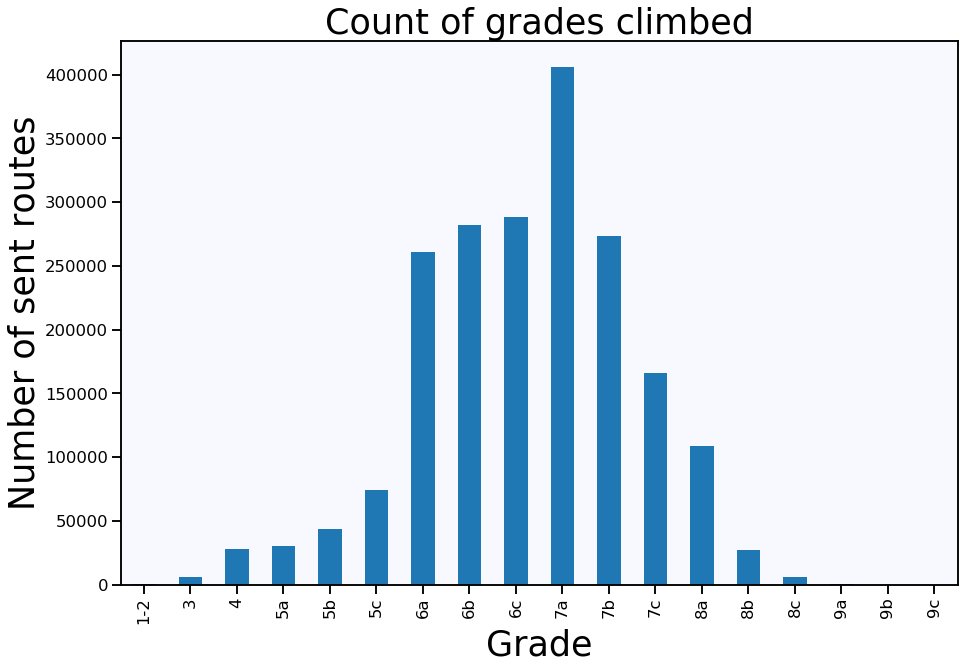

In [7]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')

#titles and labels
plt.title("Count of grades climbed", fontsize=35)
plt.ylabel("Number of sent routes", fontsize=35)
plt.xlabel("Grade", fontsize=35)
lead_values.plot(kind='bar')
# somebody claimed to climb 9c in 2015 xD


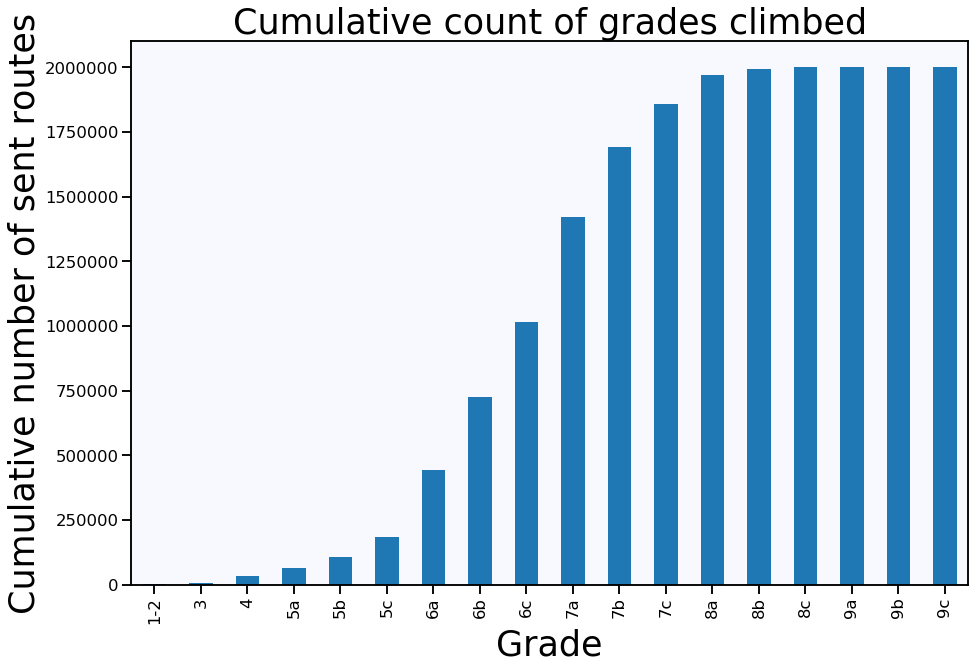

In [8]:


# cumulative grades climbed
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')
#titles and labels
plt.title("Cumulative count of grades climbed", fontsize=35)
plt.ylabel("Cumulative number of sent routes", fontsize=35)
plt.xlabel("Grade", fontsize=35)
lead_values.cumsum().plot(kind='bar')


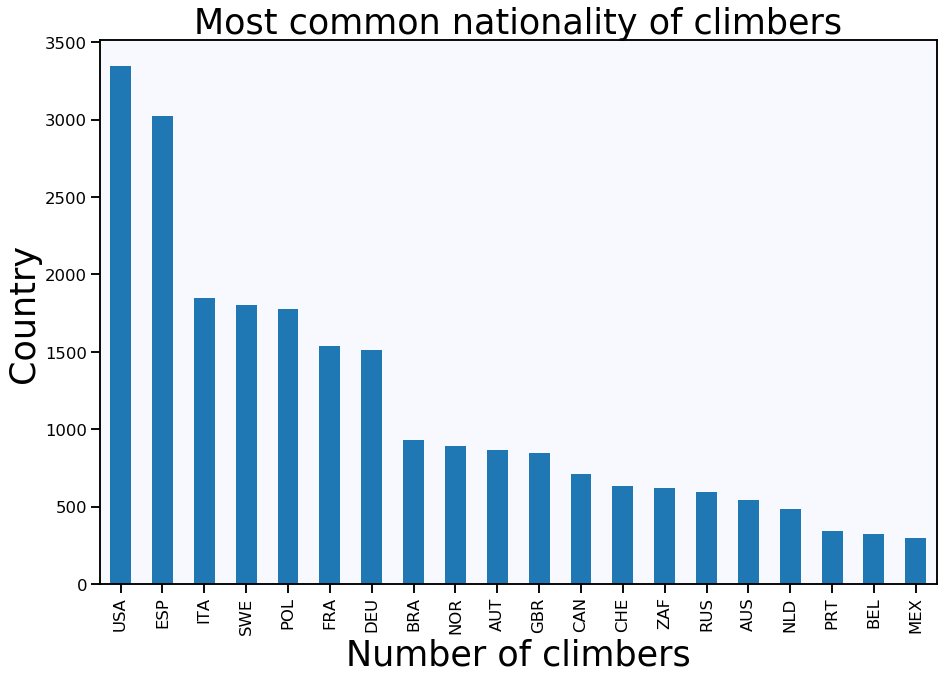

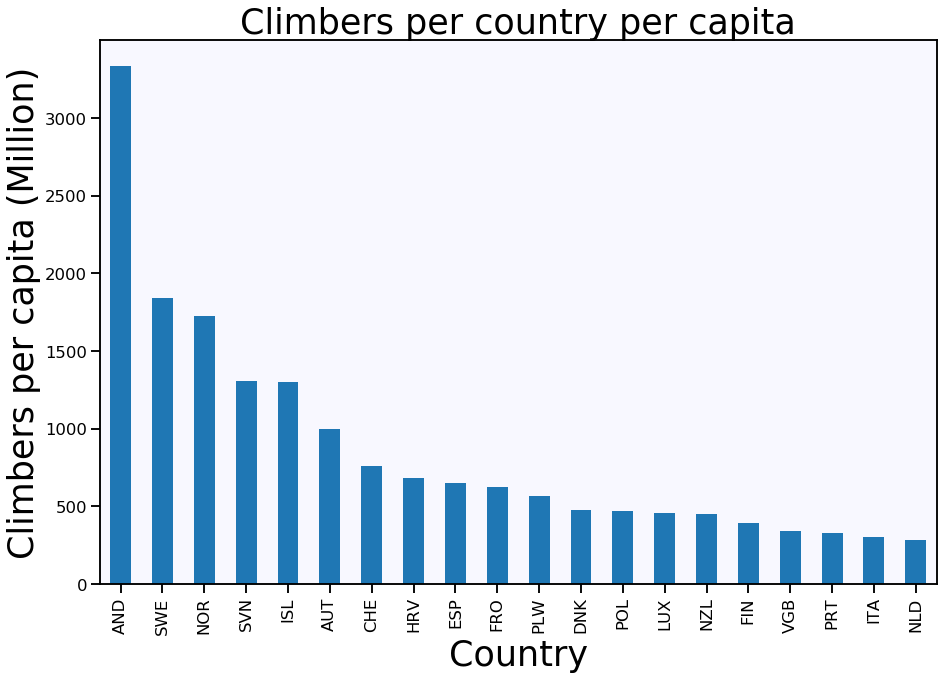

In [9]:
#load population chart from World Bank
population=pd.read_csv('../climb_analysis/population.csv',skiprows=3, index_col=1) #need to skip rows to load data

# get countreis values
nationality=users['country'].value_counts(sort=True)

most_common_nationality=nationality.head(20)

# create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')
#titles and labels
plt.title("Most common nationality of climbers", fontsize=35)
plt.ylabel("Country", fontsize=35)
plt.xlabel("Number of climbers", fontsize=35)
most_common_nationality.plot(kind='bar')




climbers_per_capita = pd.concat([nationality, population[['2015']]], axis=1).dropna(axis=0) # drops empty rows, some countries mentioned in 8a are non existent in world bank population data, or have different codes
#rename columns
climbers_per_capita = climbers_per_capita.rename(columns={ 'country':'climbers', '2015':'population'})
#calculate and assigne to dataframe
climbers_per_capita =climbers_per_capita.assign(climbers_per_capita= lambda df: df.climbers/df.population*10e6) # per milion



# create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')
#titles and labels
plt.title("Climbers per country per capita", fontsize=35)
plt.ylabel("Climbers per capita (Million)", fontsize=35)
plt.xlabel("Country", fontsize=35)
climbers_per_capita.sort_values('climbers_per_capita', ascending=False).head(20)['climbers_per_capita'].plot(kind= 'bar')


//anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


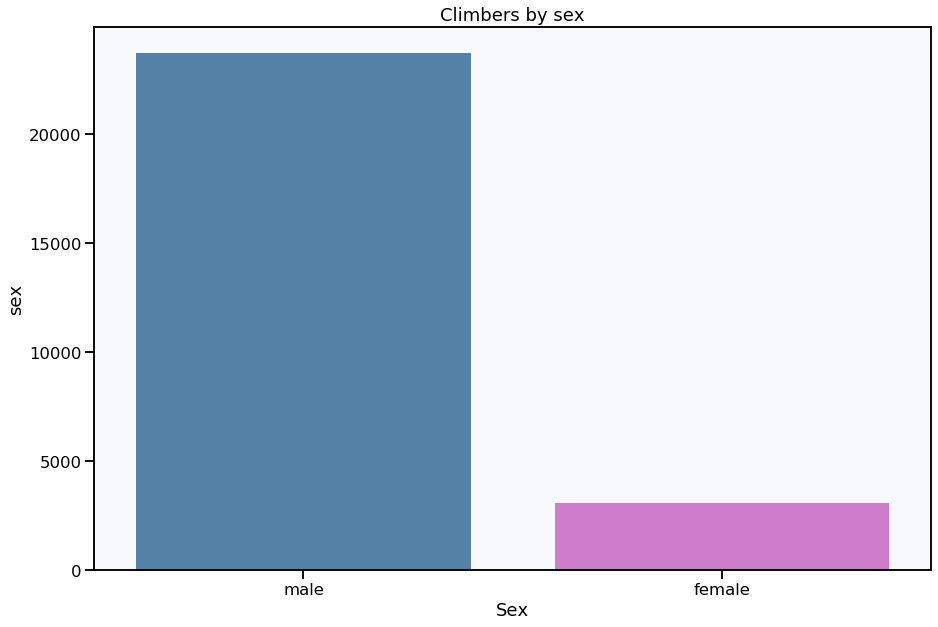

In [10]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')
#titles and labels
plt.title("Climbers by sex")
plt.ylabel("Count")
plt.xlabel("Sex")
sns.barplot(users['sex'].value_counts().rename({0:'male',1:'female'}).index, users['sex'].value_counts(), palette=colors, )


# add title to jointplot
def plot_jointplot(plot, title):
    plot.fig.suptitle(title)
    plot.ax_joint.collections[0].set_alpha(0.2)
    plot.fig.tight_layout()
    plot.fig.subplots_adjust(top=0.95)


Getting into details about weight and height of climbers.

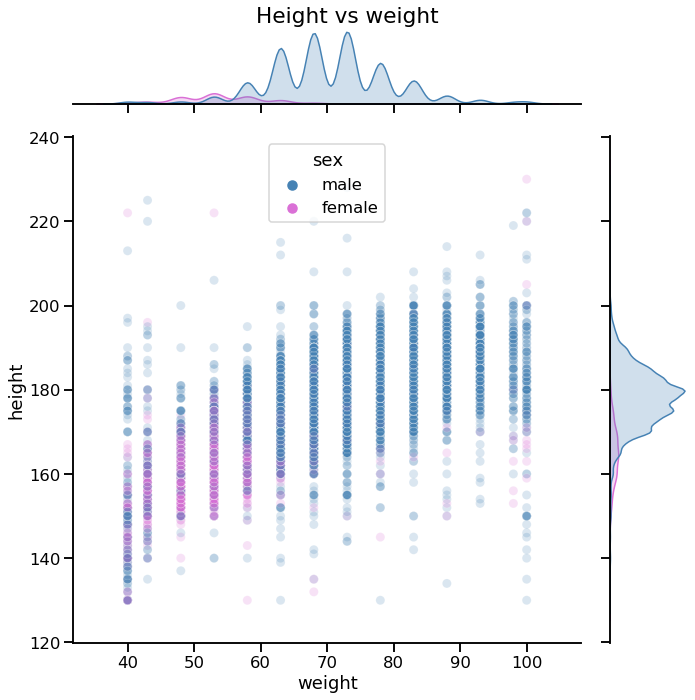

In [11]:
plot_jointplot(sns.jointplot(data=users, x="weight", y="height", hue='sex', palette = colors,  height=10,), 'Height vs weight')


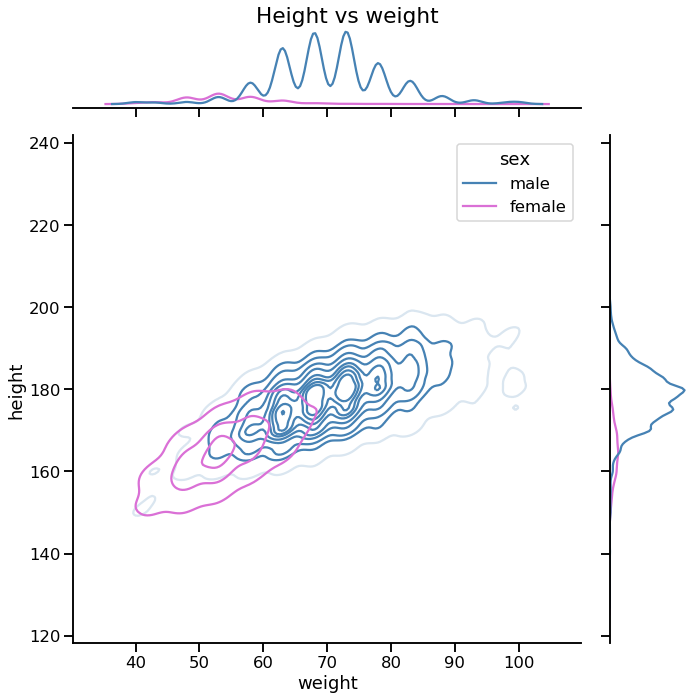

In [12]:
plot_jointplot(sns.jointplot(data=users, x="weight", y="height", hue='sex', palette = colors,  height=10, kind = 'kde'), 'Height vs weight')


Using KDE plot, one can see that there are two "islands" of weight vs height for females and males.

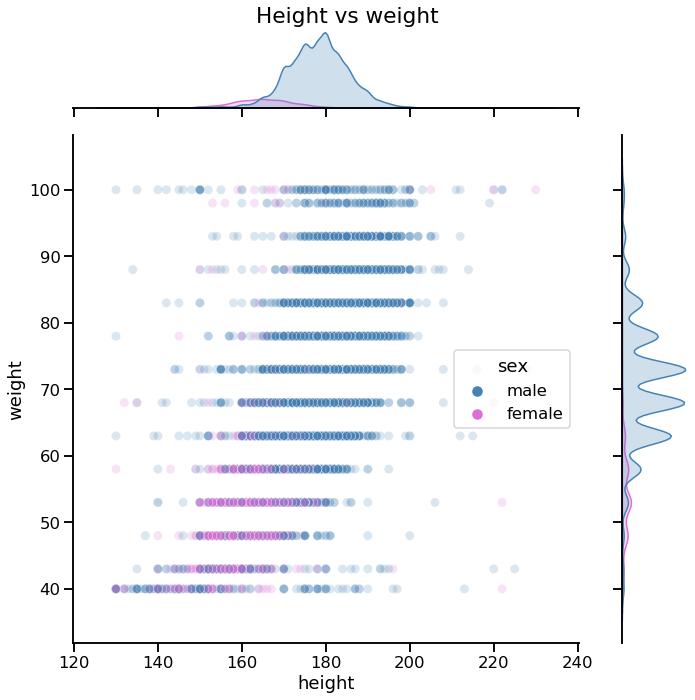

In [13]:
plot_jointplot(sns.jointplot(data=users, x="height", y="weight", hue='sex', palette = colors,  height=10,), 'Height vs weight')


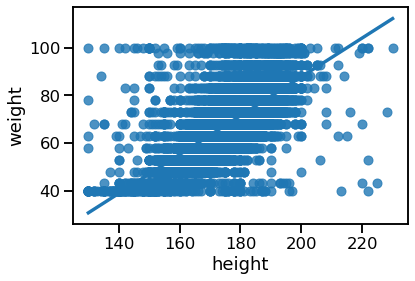

In [14]:
sns.regplot(data=users, x="height", y="weight")


In [15]:

scipy.stats.linregress([users.height,users.weight]) # calculates linear regression,  why pvalue is 0.0?

LinregressResult(slope=0.8171331928321676, intercept=-75.58822256889194, rvalue=0.6911982608425857, pvalue=0.0, stderr=0.0052161417625559295)

There is correlation between height and weight. yeah right, wow...
Linear regression should not be used when we have two or more supgroups, and there is no correlation in supgroups.
Next code snippet checks if there is linear correlation in each supgroup.


In [16]:
# Calculates BMI for users, and appends a column
users =users.assign(BMI= lambda df: df.weight/(df.height*0.01)**2) # per milion


# selects rows from dataframe if column value is...
#users.loc[users['sex'] == 0]
males = users.loc[users['sex'] == 'male']

females = users.loc[users['sex'] == 'female']

In [17]:
print(scipy.stats.linregress([males.height,males.weight]))
print(scipy.stats.linregress([females.height,females.weight]))
# there is correlation, oh wow.

LinregressResult(slope=0.7183705001569921, intercept=-57.42320699033914, rvalue=0.6004044722795137, pvalue=0.0, stderr=0.006209968561551584)
LinregressResult(slope=0.5741794162699385, intercept=-40.123458918775206, rvalue=0.5788367420848994, pvalue=1.358775857735279e-275, stderr=0.014565593815917577)


//anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


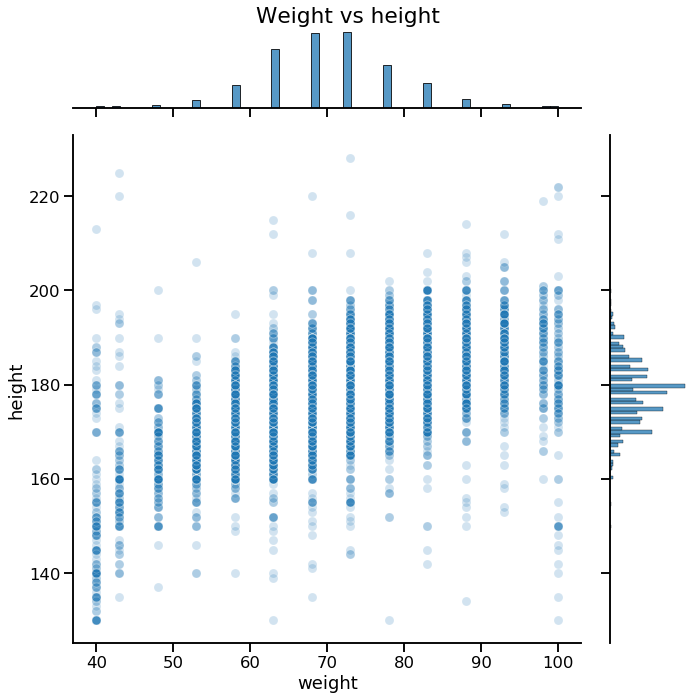

In [18]:
plot_jointplot(sns.jointplot(males.weight, males.height,kind ='scatter', height=10), 'Weight vs height')


//anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


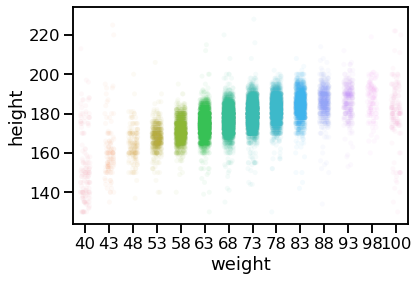

In [19]:
#just playing with sns
sns.stripplot(males.weight, males.height, jitter=0.2, alpha=0.05) # ładne to

//anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
//anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


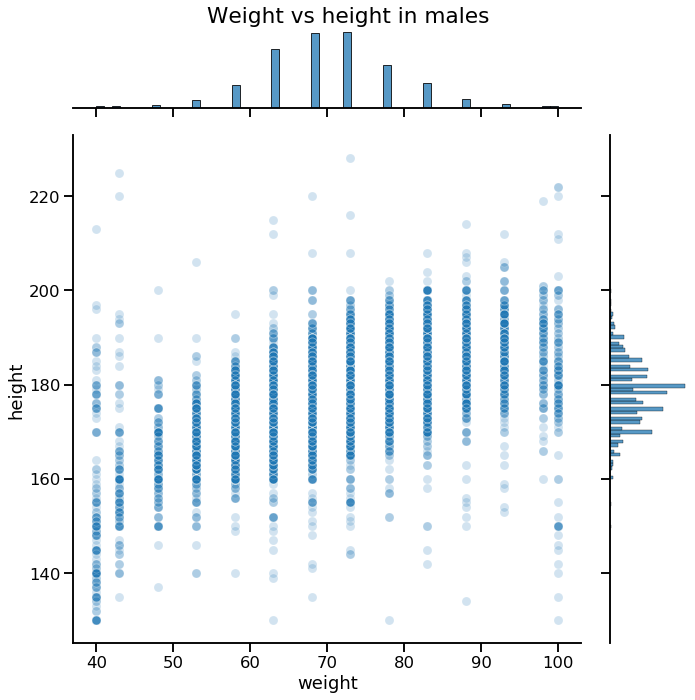

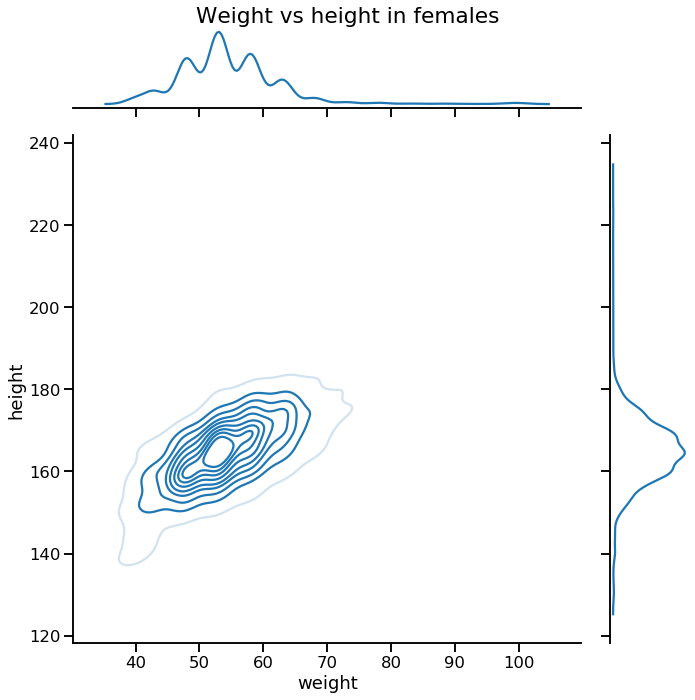

In [20]:


plot_jointplot(sns.jointplot(males.weight, males.height,kind ='scatter',height=10), title= 'Weight vs height in males')

#users.plot(y='height', x = 'weight', kind ='hexbin')

plot_jointplot(sns.jointplot(females.weight, females.height,kind ='kde',height=10), title= 'Weight vs height in females')




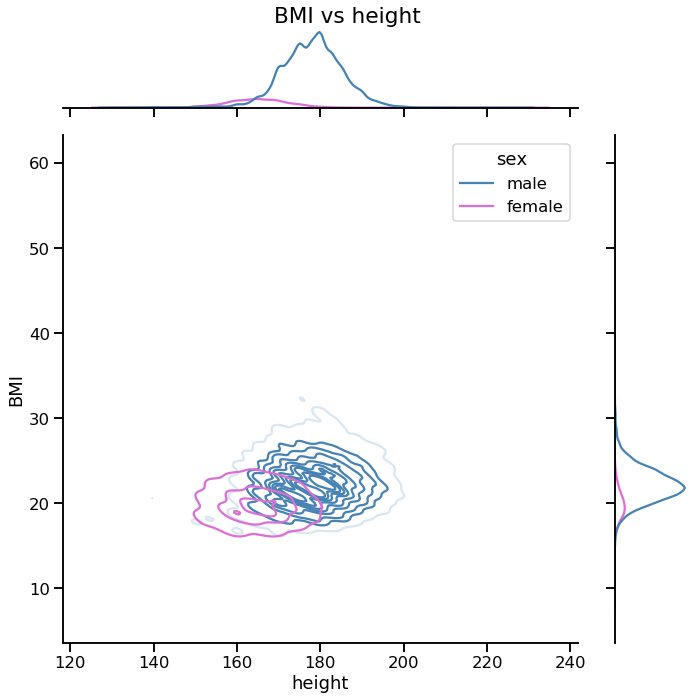

In [21]:
plot_jointplot(sns.jointplot(data=users, x="height", y="BMI", hue='sex', palette = colors,  height=10, kind = 'kde'),  title= 'BMI vs height')


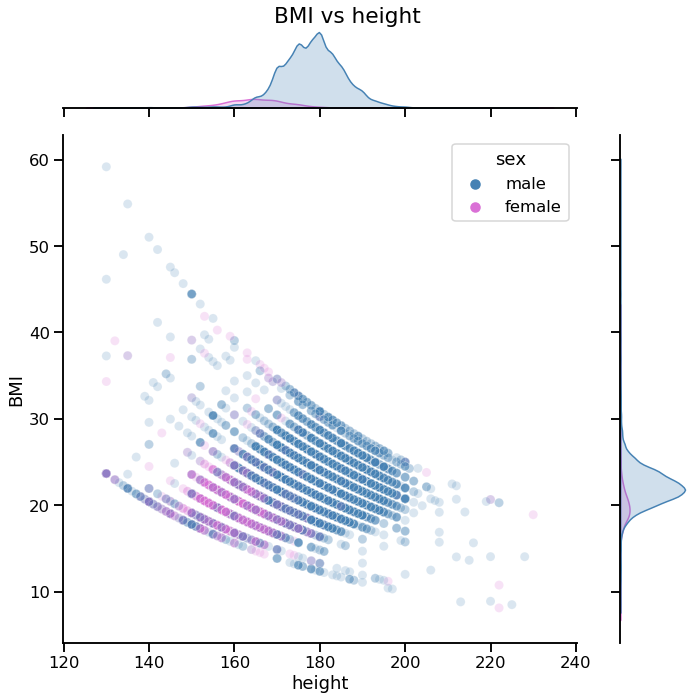

In [22]:
plot_jointplot(sns.jointplot(data=users, x="height", y="BMI", hue='sex', palette = colors,  height=10, kind = 'scatter'),  title= 'BMI vs height')


There is relation between BMI and height. Because how BMI is calculated, the relation between height and weight is not linear.

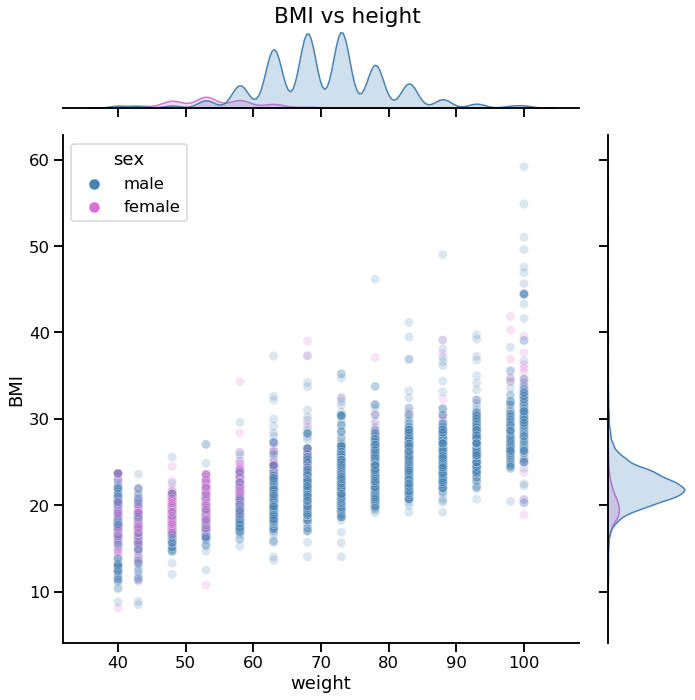

In [23]:
plot_jointplot(sns.jointplot(data=users, x="weight", y="BMI", hue='sex', palette = colors,  height=10, kind = 'scatter'),  title = 'BMI vs height')

Let's dive into how heigh, weight and BMI influences max grade of a climber.
* Get max grade for a climber _OK
* Plot some 2D graphs with weight, height, BMI, and max grade. _OK


In [24]:
#get max grades for users
max_grades=lead.groupby('user_id')
max_grades=max_grades.max()

In [25]:
users= users.rename(columns={'id':'user_id'})

In [26]:
#users['grade'] = users['id'].map(max_grades.set_index('id')['grade'])
users2 = pd.DataFrame()
users2 = users.merge(max_grades, on='user_id', how='right')

users2['bin_height_coded']=pd.qcut(users2['height'],10).cat.codes

users2['bin_BMI_coded']=pd.qcut(users2['BMI'],10).cat.codes

users2['bin_height']=pd.qcut(users2['height'],10)

users2['bin_BMI']=pd.qcut(users2['BMI'],10)



In [27]:
#get columns for grade_id and grade
grades_dict=users2[['grade_id', 'grade']]
# set grade_id as index, and then create dictionary
grades_dict = grades_dict.set_index('grade_id')['grade'].to_dict()
# sort dictionary
grades_dict = dict(sorted(grades_dict.items()))

In [28]:
BMI_dict=users2[['bin_BMI_coded', 'bin_BMI']]

#apply funcion on one column
BMI_dict['bin_BMI'] = BMI_dict['bin_BMI'].apply(lambda x: x.mid.round(decimals=1))
BMI_dict = BMI_dict.set_index('bin_BMI_coded')['bin_BMI'].to_dict()

BMI_dict = dict(sorted(BMI_dict.items()))


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
height_dict=users2[['bin_height_coded', 'bin_height']]

#apply funcion on one column
height_dict['bin_height'] = height_dict['bin_height'].apply(lambda x: x.mid.round(decimals=1))
height_dict = height_dict.set_index('bin_height_coded')['bin_height'].to_dict()

height_dict = dict(sorted(height_dict.items()))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
#get columns for grade_id and grade
grades_dict=users2[['grade_id', 'grade']]
# set grade_id as index, and then create dictionary
grades_dict = grades_dict.set_index('grade_id')['grade'].to_dict()
# sort dictionary
grades_dict = dict(sorted(grades_dict.items()))

[Text(0, 0, '4'),
 Text(0, 0, '5a'),
 Text(0, 0, '5c'),
 Text(0, 0, '6a'),
 Text(0, 0, '6b'),
 Text(0, 0, '6c'),
 Text(0, 0, '7a'),
 Text(0, 0, '7b'),
 Text(0, 0, '7c'),
 Text(0, 0, '8a'),
 Text(0, 0, '8b')]

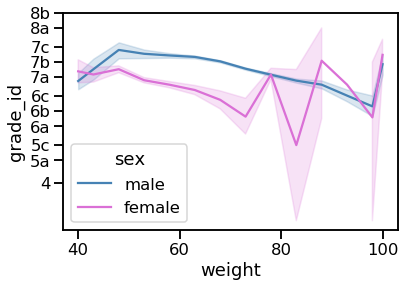

In [31]:
ax = plt.gca()
sns.lineplot(data=users2, x="weight", y="grade_id", hue="sex", palette = colors)
ax.set_yticks([i for i in grades_dict.keys()][3:-7][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict[i] for i in yticks])







[Text(0, 0.5, 'grade'), Text(0.5, 0, 'height')]

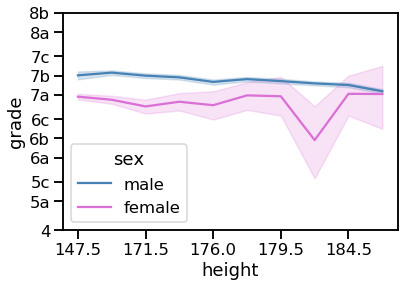

In [32]:
ax = plt.gca()
sns.lineplot(data=users2, x="bin_height_coded", y="grade_id", hue="sex", palette = colors)
ax.set_yticks([i for i in grades_dict.keys()][3:-7][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict[i] for i in yticks])



####
ax.set_xticks([i for i in height_dict.keys()][::2])
xticks = ax.get_xticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_xticklabels([height_dict[i] for i in xticks])

ax.set(xlabel='height', ylabel='grade')




In [33]:


#To select rows whose column value equals a scalar, some_value, use ==. If number use number instead 'number'

# then using iloc first row is selected, and for the row grade_y is taken
#users2.loc[users2['grade_id'] == 62].iloc[0][['grade_y']]



[Text(0, 0.5, 'grade'), Text(0.5, 0, 'BMI')]

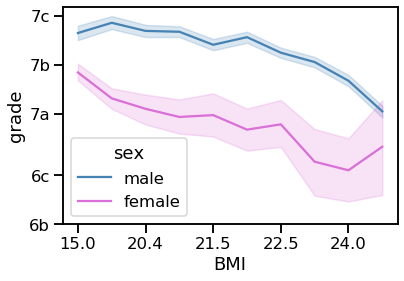

In [34]:
ax = plt.gca()


sns.lineplot(data=users2, x='bin_BMI_coded' ,y="grade_id", hue="sex", palette = colors )
#spędziłęm nad tym dużo czasu

#ustawia zakres w którym są wartości y, wybiera co drugą wartość [::2]
ax.set_yticks([i for i in grades_dict.keys()][10:-11][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict[i] for i in yticks])






####
ax.set_xticks([i for i in BMI_dict.keys()][::2])
xticks = ax.get_xticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_xticklabels([BMI_dict[i] for i in xticks])


ax.set(xlabel='BMI', ylabel='grade')







How much time needed to progress?


In [35]:
#group lead table by user_id, and grade, nth selects first ascent 
lead_analysis = lead.groupby(['user_id', 'grade'] )
lead_analysis = lead_analysis.nth(0, dropna=None).reset_index() # reset_index removes multiindex made by groupby

In [36]:
lead_pivot= lead_analysis.pivot_table(index = 'user_id', columns = ['grade'], values ='date')



CPU times: user 587 ms, sys: 31.5 ms, total: 619 ms
Wall time: 722 ms


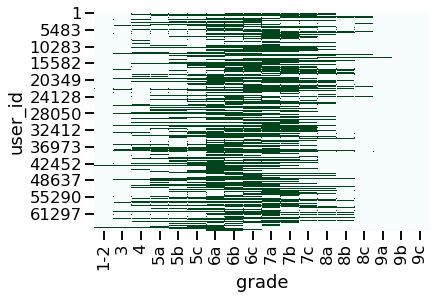

In [37]:
%%time
#notnull returns dataframe with True/False information applymap with lambda function converts it to 0 and 1
sns.heatmap(lead_pivot.notnull().applymap(lambda x: int(x)), cbar=False, cmap='BuGn')

CPU times: user 308 ms, sys: 11.4 ms, total: 320 ms
Wall time: 320 ms


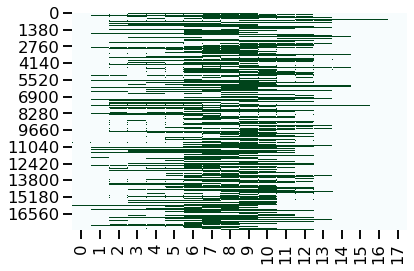

In [38]:
%%time
sns.heatmap(np.where( lead_pivot.notnull() == False, 0, 1 ), cbar=False, cmap='BuGn')

In [39]:
print("Green shows available data, blue missing data")
print(f"Number of all sends: {lead_pivot.notnull().sum().sum()}")
print(f"Number of climbers: {len(lead_pivot)}")

Green shows available data, blue missing data
Number of all sends: 94960
Number of climbers: 17937


In [239]:
# calculate how much time spet at each grade with diff function, diff subtracts each column from previous

time_spent = lead_pivot.diff(axis = 1 ) # for some reason it may give negative result, why?
#time_spent = time_spent.applymap(lambda x: np.nan if x <0 else x ) # replaces negative values with NaN



In [240]:
time_spent= np.where(time_spent <0 , np.nan, time_spent/(3600*24*30)) # replace negative values with NaN and convert remaining to months


In [241]:
time_spent=pd.DataFrame(time_spent,  columns = lead_pivot.columns.copy(), index=lead_pivot.index.copy())
#index=lead_pivot.index.copy(),

In [242]:
# time_spent is a dataframe that contains time spent on each grade, so in order to get information about how much time is
# needed to achieve certain grade there is need to reindex data by shifting down a grade

time_spent= time_spent.rename(columns = lambda c: time_spent.columns[time_spent.columns.get_loc(c)-1])
time_spent= time_spent.drop('9c', axis =1)

In [243]:
#Calculate cumulative time needed for climbing a grade
time_spent=time_spent.cumsum(axis=1)

In [289]:
# remove outliers
# set treshold
thresh = time_spent.quantile(q=0.95, axis='index')
#remove outliers with np.where, copy columns and index name
time_spent_clean = pd.DataFrame(np.where(time_spent<thresh.values, time_spent, np.nan), columns = time_spent.columns.copy(), index=time_spent.index.copy())


In [290]:
#convert months to years with .apply
df = time_spent_clean.apply(lambda x: x/12).reset_index().melt('user_id', var_name='Grade',  value_name='Years')# I don't know what melt does


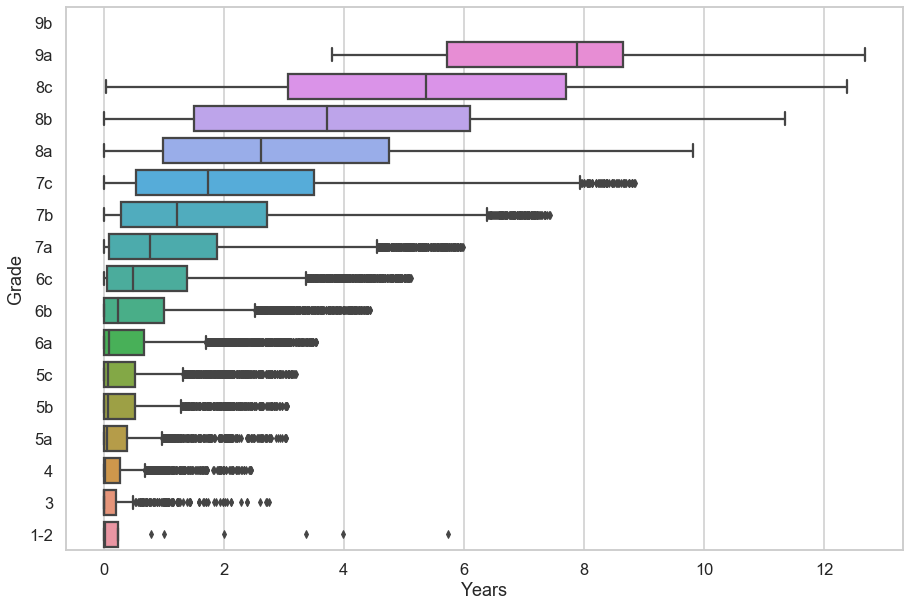

In [291]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 10))
ax = plt.gca()
sns.boxplot(y='Grade', x="Years",  data=df,)
ax.invert_yaxis() # invert y axis

8a users are ubermench. Now it's time for bouldering

In [292]:
#for climbers defined in the beggining of this file get bouldering data
boulder = pd.read_sql_query("SELECT id, user_id, grade_id, date, year, last_year, rec_date, country, project_ascent_date, rating  \
 FROM ascent\
 WHERE climb_type = '1'\
 AND user_id in (SELECT id FROM user  WHERE height <='230' AND height >= '130' AND weight  >0)\
  ;", con)



In [294]:
# Tidy grades
boulder['grade'] = boulder.apply(lambda row : bin_grades(row['grade_id']), axis = 1)

boulder_values = boulder['grade'].value_counts().sort_index() # still need reindexing, because of <3
#lead_values=lead_values.reindex(lead_values.index[-1:].union(lead_values.index[:-1], sort=False))



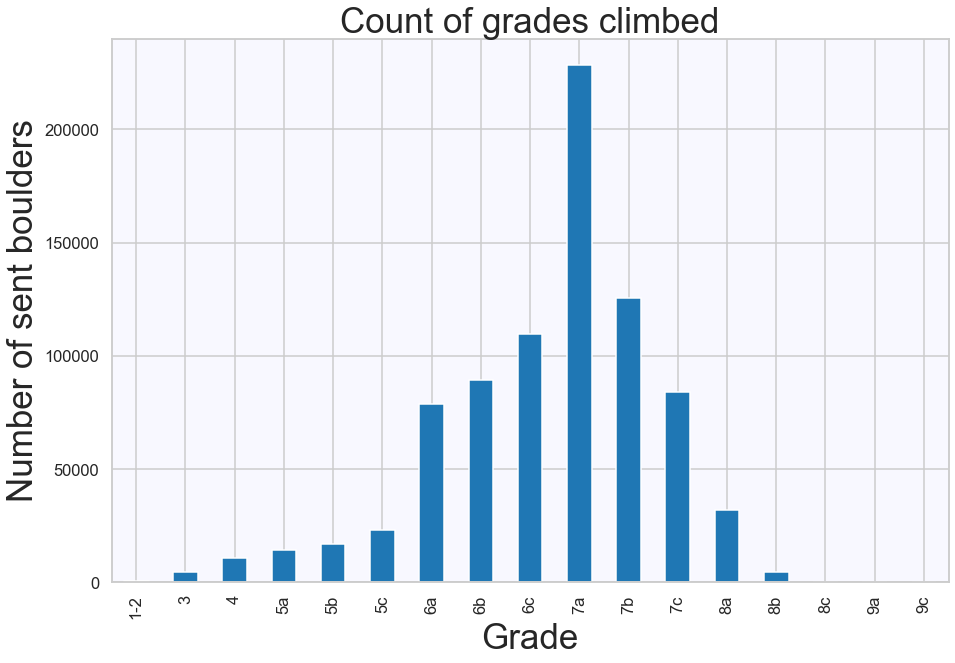

In [297]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')

#titles and labels
plt.title("Count of grades climbed", fontsize=35)
plt.ylabel("Number of sent boulders", fontsize=35)
plt.xlabel("Grade", fontsize=35)
boulder_values.plot(kind='bar')
# somebody claimed to climb 9c in 2015 xD



Bouldering is less popular than rope climbing, at least when it comes to logging ascents. 

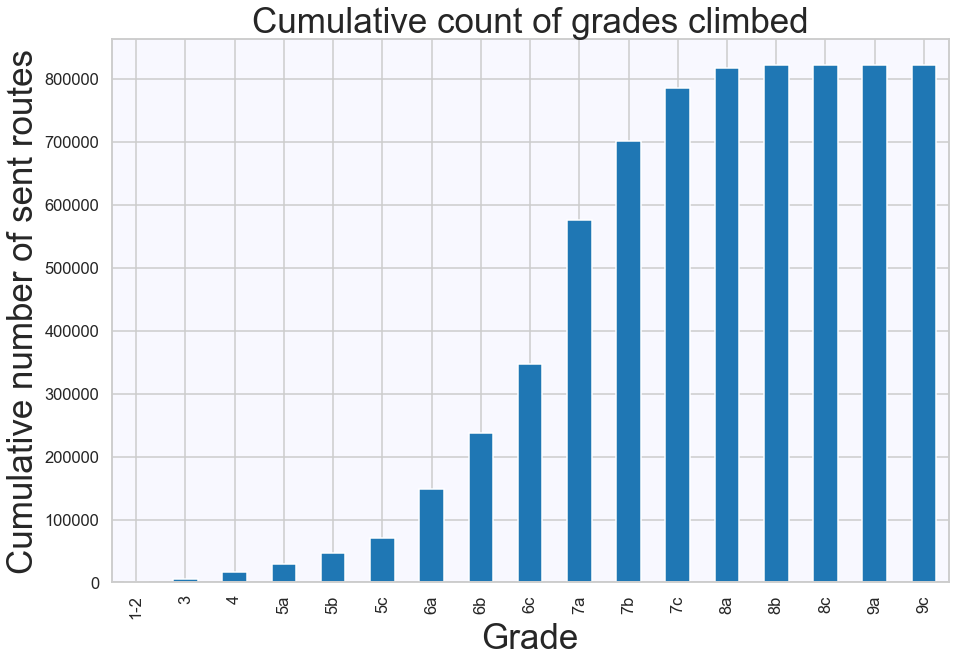

In [296]:


# cumulative grades climbed
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_facecolor('ghostwhite')
#titles and labels
plt.title("Cumulative count of grades climbed", fontsize=35)
plt.ylabel("Cumulative number of sent boulders", fontsize=35)
plt.xlabel("Grade", fontsize=35)
boulder_values.cumsum().plot(kind='bar')



In [301]:
#get max grades for sent boulders
max_boulder=boulder.groupby('user_id')
max_boulder=max_boulder.max()

In [302]:
#users['grade'] = users['id'].map(max_grades.set_index('id')['grade'])
users_boulder = pd.DataFrame()
users_boulder = users.merge(max_boulder, on='user_id', how='right')

users_boulder['bin_height_coded']=pd.qcut(users_boulder['height'],10).cat.codes

users_boulder['bin_BMI_coded']=pd.qcut(users_boulder['BMI'],10).cat.codes

users_boulder['bin_height']=pd.qcut(users_boulder['height'],10)

users_boulder['bin_BMI']=pd.qcut(users_boulder['BMI'],10)




In [309]:
colors

[array([0.98431373, 0.70588235, 0.68235294, 1.        ]),
 array([0.98431373, 0.70588235, 0.68235294, 1.        ]),
 array([0.70196078, 0.80392157, 0.89019608, 1.        ]),
 array([0.70196078, 0.80392157, 0.89019608, 1.        ]),
 array([0.70196078, 0.80392157, 0.89019608, 1.        ]),
 array([0.8       , 0.92156863, 0.77254902, 1.        ]),
 array([0.8       , 0.92156863, 0.77254902, 1.        ]),
 array([0.87058824, 0.79607843, 0.89411765, 1.        ]),
 array([0.87058824, 0.79607843, 0.89411765, 1.        ]),
 array([0.87058824, 0.79607843, 0.89411765, 1.        ]),
 array([0.87058824, 0.79607843, 0.89411765, 1.        ])]

In [304]:
#get columns for grade_id and grade
grades_dict_b=users_boulder[['grade_id', 'grade']]
# set grade_id as index, and then create dictionary
grades_dict_b = grades_dict_b.set_index('grade_id')['grade'].to_dict()
# sort dictionary
grades_dict_b = dict(sorted(grades_dict_b.items()))

[Text(0, 0, '4'),
 Text(0, 0, '5b'),
 Text(0, 0, '6a'),
 Text(0, 0, '6b'),
 Text(0, 0, '6c'),
 Text(0, 0, '7a'),
 Text(0, 0, '7b'),
 Text(0, 0, '7c'),
 Text(0, 0, '8a')]

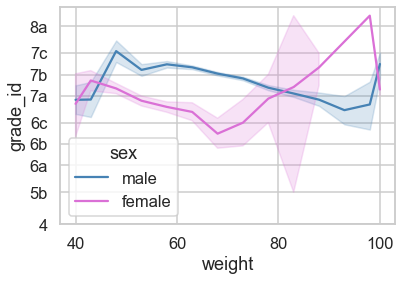

In [312]:
ax = plt.gca()
sns.lineplot(data=users_boulder, x="weight", y="grade_id", hue="sex", palette = colors)
ax.set_yticks([i for i in grades_dict_b.keys()][3:-7][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict_b[i] for i in yticks])




[Text(0, 0.5, 'grade'), Text(0.5, 0, 'height')]

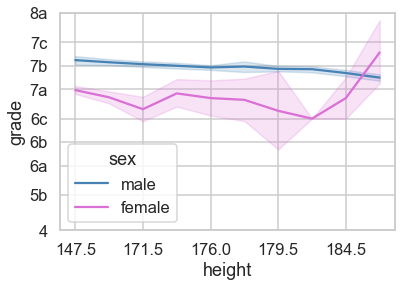

In [316]:
ax = plt.gca()
sns.lineplot(data=users_boulder, x="bin_height_coded", y="grade_id", hue="sex", palette = colors)
ax.set_yticks([i for i in grades_dict_b.keys()][3:-7][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict_b[i] for i in yticks])

####
ax.set_xticks([i for i in height_dict.keys()][::2])
xticks = ax.get_xticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_xticklabels([height_dict[i] for i in xticks])

ax.set(xlabel='height', ylabel='grade')

[Text(0, 0.5, 'grade'), Text(0.5, 0, 'BMI')]

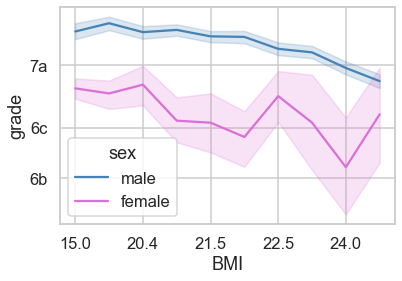

In [318]:


ax = plt.gca()


sns.lineplot(data=users_boulder, x='bin_BMI_coded' ,y="grade_id", hue="sex", palette = colors )
#spędziłęm nad tym dużo czasu

#ustawia zakres w którym są wartości y, wybiera co drugą wartość [::2]
ax.set_yticks([i for i in grades_dict_b.keys()][10:-11][::2])
yticks = ax.get_yticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_yticklabels([grades_dict_b[i] for i in yticks])






####
ax.set_xticks([i for i in BMI_dict.keys()][::2])
xticks = ax.get_xticks()

# dla wartości z yticks wybiera ze słownika odpowiednią wycenę
ax.set_xticklabels([BMI_dict[i] for i in xticks])


ax.set(xlabel='BMI', ylabel='grade')



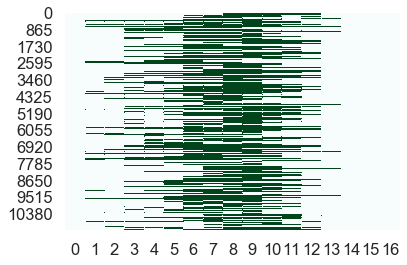

In [321]:

#group bouldering table by user_id, and grade, nth selects first ascent 
boulder_analysis = boulder.groupby(['user_id', 'grade'] )
boulder_analysis = boulder_analysis.nth(0, dropna=None).reset_index() # reset_index removes multiindex made by groupby

boulder_pivot= boulder_analysis.pivot_table(index = 'user_id', columns = ['grade'], values ='date')



# see what data we have and what data is missing
sns.heatmap(np.where( boulder_pivot.notnull() == False, 0, 1 ), cbar=False, cmap='BuGn')

How much time needed to progress in bouldering

In [322]:
print("Green shows available data, blue missing data")
print(f"Number of all sends: {boulder_pivot.notnull().sum().sum()}")
print(f"Number of climbers: {len(boulder_pivot)}")

Green shows available data, blue missing data
Number of all sends: 52756
Number of climbers: 11235


In [330]:
# calculate how much time spet at each grade with diff function, diff subtracts each column from previous

time_spent_b = boulder_pivot.diff(axis = 1 ) # for some reason it may give negative result, why?
#time_spent = time_spent.applymap(lambda x: np.nan if x <0 else x ) # replaces negative values with NaN



In [331]:
time_spent_b= np.where(time_spent_b <0 , np.nan, time_spent_b/(3600*24*30)) # replace negative values with NaN and convert remaining to months


In [332]:
time_spent_b=pd.DataFrame(time_spent_b,  columns = boulder_pivot.columns.copy(), index=boulder_pivot.index.copy())
#index=lead_pivot.index.copy(),

In [333]:
# time_spent is a dataframe that contains time spent on each grade, so in order to get information about how much time is
# needed to achieve certain grade there is need to reindex data by shifting down a grade

time_spent_b= time_spent_b.rename(columns = lambda c: time_spent_b.columns[time_spent_b.columns.get_loc(c)-1])
time_spent_b= time_spent_b.drop('9c', axis =1)

In [243]:
#Calculate cumulative time needed for climbing a grade
time_spent_b=time_spent_b.cumsum(axis=1)

In [335]:
# remove outliers
# set treshold
thresh = time_spent_b.quantile(q=0.95, axis='index')
#remove outliers with np.where, copy columns and index name
time_spent_b_clean = pd.DataFrame(np.where(time_spent_b<thresh.values, time_spent_b, np.nan), columns = time_spent_b.columns.copy(), index=time_spent_b.index.copy())


In [338]:
#convert months to years with .apply
df_bouldering = time_spent_b_clean.apply(lambda x: x/12).reset_index().melt('user_id', var_name='Grade',  value_name='Years')# I don't know what melt does


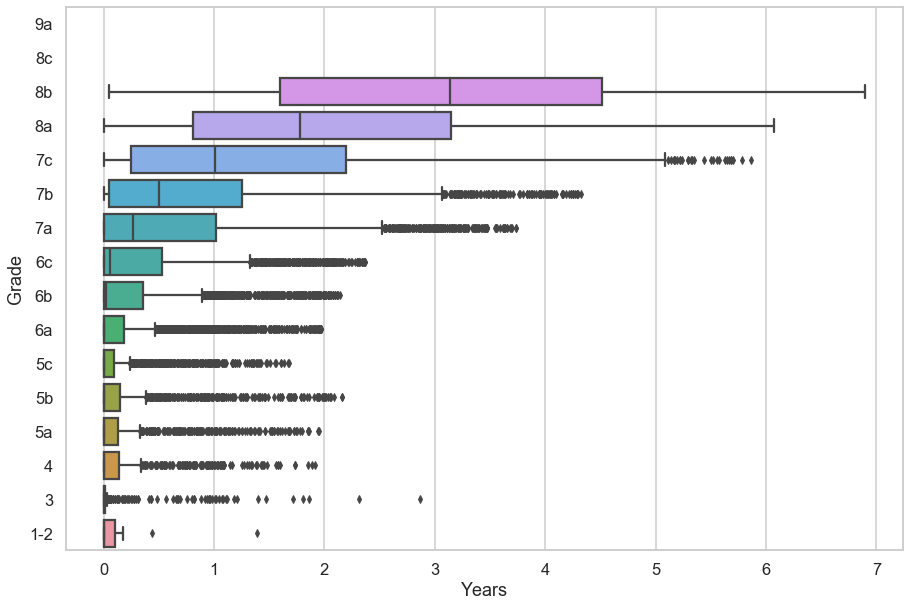

In [339]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 10))
ax = plt.gca()
sns.boxplot(y='Grade', x="Years",  data=df_bouldering,)
ax.invert_yaxis() # invert y axis

There is need to do some quantile regression for max grade